# Import Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from brian2 import *
from brian2tools import brian_plot, plot_state
from IPython.display import HTML
from TacNet import TacNet
from utils import display_video

set_device("cpp_standalone")


def wrap2pi(angles):
    theta = np.array(angles)
    theta = theta.reshape(-1)
    n = np.floor(theta / np.pi)
    return theta - n * np.pi


def extend_dataset(data, labels, n=1, shuffle=True, crop=None):
    if not isinstance((data, labels), (np.ndarray, np.ndarray)):
        data = np.asarray(data)
        labels = np.asarray(labels)

    if shuffle:
        indices = np.random.permutation(np.arange(len(labels)))
        data = data[indices, :]
        labels = labels[indices]

    if crop is not None:
        data = data[:crop, :, :]
        labels = labels[:crop]

    return np.repeat(data, n, axis=0), np.repeat(labels, n, axis=0)

# Unsupervised Learning of Edge Orientation Detection with [TacNet](TacNet.py)

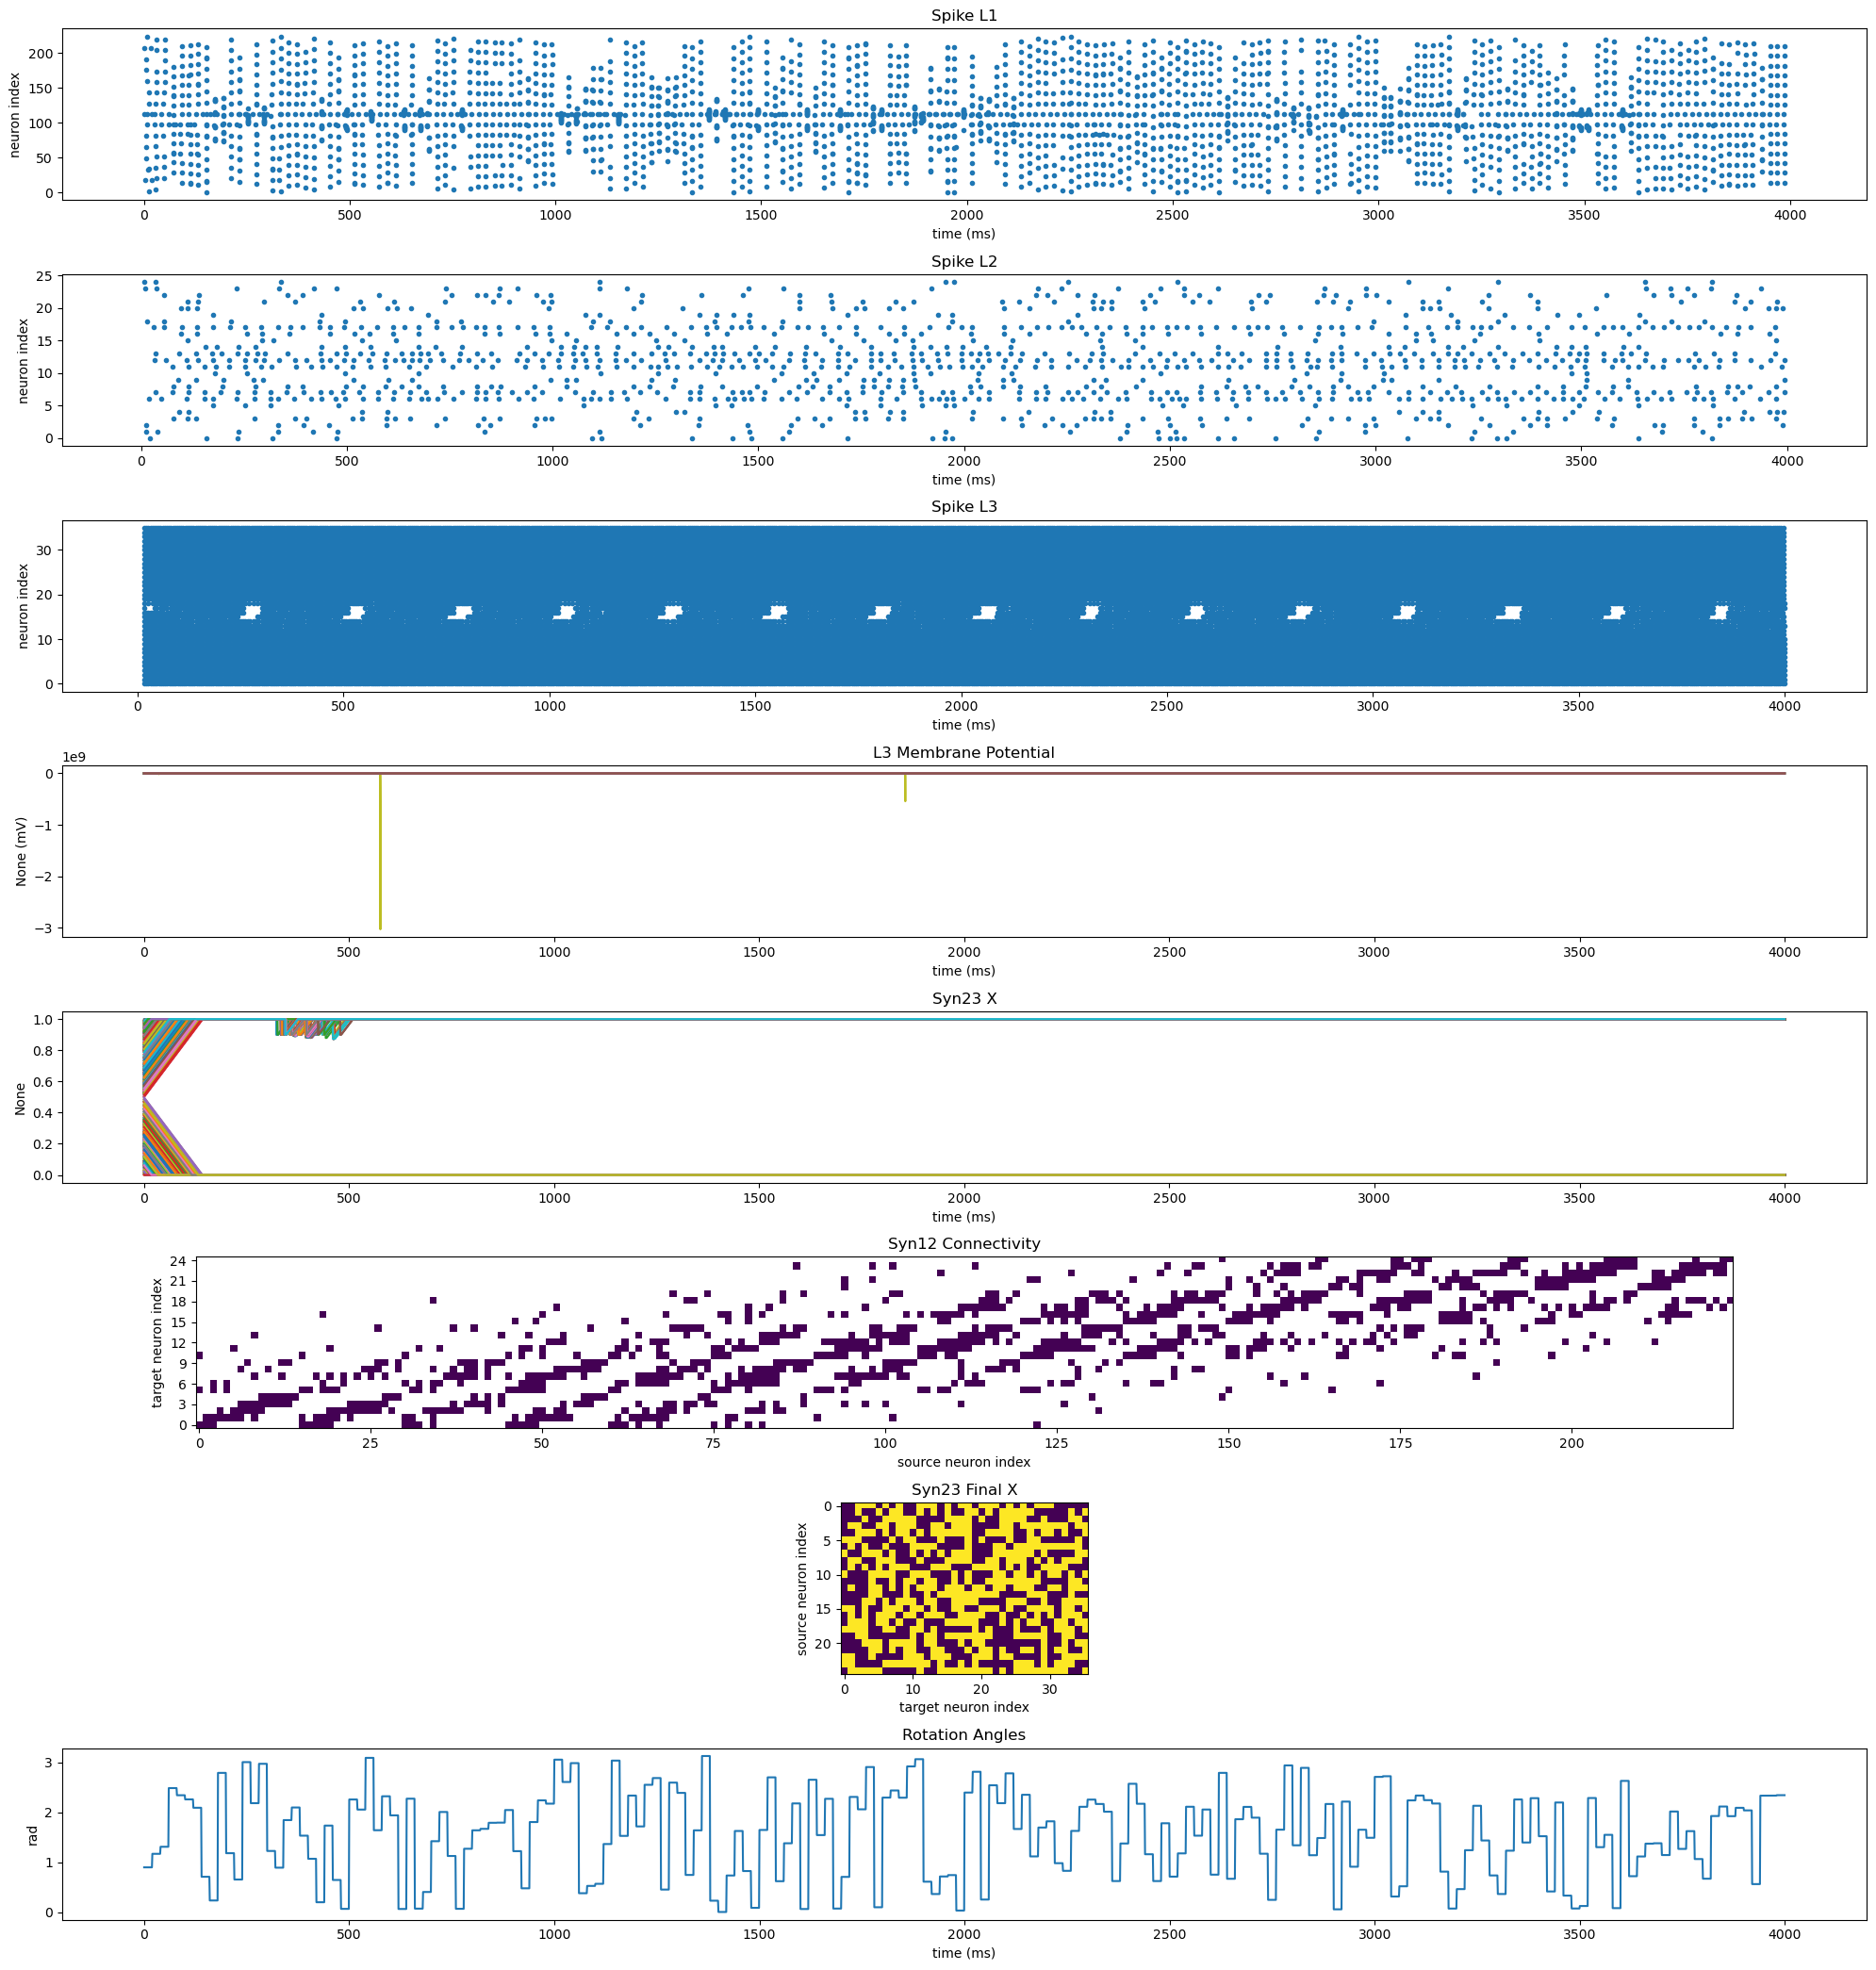

In [5]:
# Prepare dataset
dt = 1 * ms
site_name = "sharp_site"
dataset = np.load("../data/touch.pkl", allow_pickle=True)
sensordata = dataset[site_name]["sensordata"]
rot_orientations = dataset[site_name]["orientations"]
data, orientations = extend_dataset(sensordata, rot_orientations, n=20, crop=200)

# Convert values to spikes
length, height, width = data.shape
inputs = data.reshape(length, -1)
inputs[inputs > 0] = 1.0
I = TimedArray(inputs * 200 * pA, dt=dt)

# Prepare simulation
duration = I.values.shape[0] * dt
num_neurons = [height * width, 25, 36]
model = TacNet(num_neurons)
mons = model.run(I, duration)

# Plot results
fig, axs = plt.subplots(8, 1, figsize=(20, 21))
for i in range(3):
    axs[i].set_title("Spike L" + str(i + 1))
    brian_plot(mons["SpikeMonitor_L" + str(i + 1)], axes=axs[i])

axs[3].set_title("L3 Membrane Potential")
plot_state(mons["StateMonitor_L3"].t, mons["StateMonitor_L3"].v.T, axes=axs[3])
axs[4].set_title("Syn23 X")
plot_state(mons["StateMonitor_Syn23"].t, mons["StateMonitor_Syn23"].X.T, axes=axs[4])
axs[5].set_title("Syn12 Connectivity")
brian_plot(model.net["Syn12"], axes=axs[5])
axs[6].set_title("Syn23 Final X")
axs[6].set_xlabel("target neuron index")
axs[6].set_ylabel("source neuron index")
axs[6].imshow(model.net["Syn23"].X_[:].reshape((num_neurons[1], num_neurons[2])))
axs[7].plot(wrap2pi(orientations))
axs[7].set_title("Rotation Angles")
axs[7].set_xlabel("time (ms)")
axs[7].set_ylabel("rad")
plt.tight_layout()
plt.show()

# Find centre of the spatial distribution

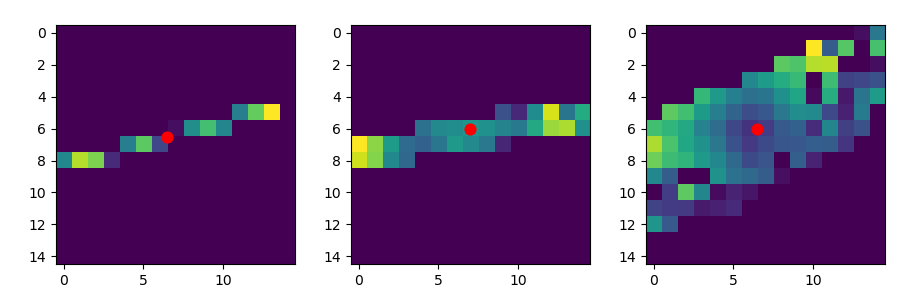

In [607]:
%matplotlib widget

sample_id = 600
dataset = np.load("../data/touch.pkl", allow_pickle=True)
samples = []
samples.append(dataset["sharp_site"]["sensordata"][sample_id])
samples.append(dataset["round_site"]["sensordata"][sample_id])
samples.append(dataset["wedge_site"]["sensordata"][sample_id])
nsamples = len(samples)

ims = []
fig, ax = plt.subplots(1, nsamples, figsize=(nsamples * 3, 3))
for i, sample in enumerate(samples):
    loc = np.where(sample > 0)
    x, y = np.median(loc[0]), np.median(loc[1])
    im = ax[i].imshow(sample)
    ims.append(im)
    ax[i].scatter(y, x, s=60, c="red")

plt.tight_layout()
plt.show()

# Generative MGGD Spatial Model

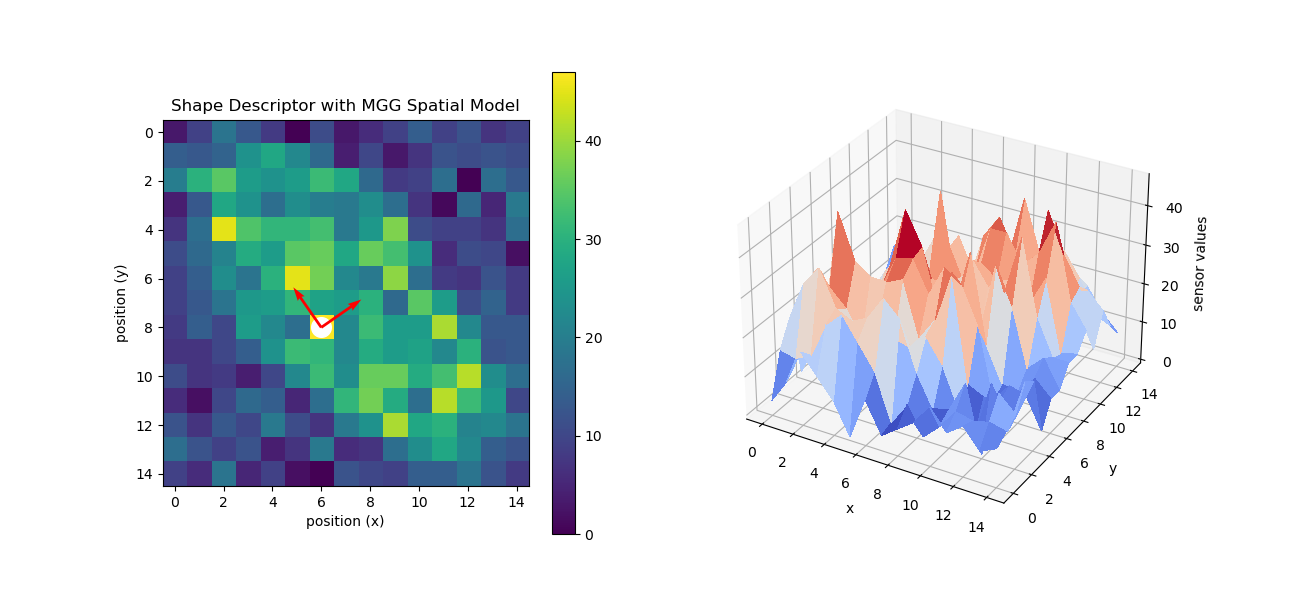

In [196]:
from random import random

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from numpy import linalg as LA

%matplotlib widget


def genScatter():
    alpha = random() * 2 * np.pi
    beta = alpha + np.pi / 2.0

    Q = np.array([[np.cos(alpha), np.cos(beta)], [np.sin(alpha), np.sin(beta)]])
    P = np.diag(np.random.rand(2))
    M = np.matmul(np.matmul(Q, P), LA.inv(Q))

    return M * p / M.trace()


def normalize2(xs, scope):
    xs = (xs - xs.min()) / (xs.max() - xs.min())
    return np.round(xs * (scope - 1))


# MGGD stochastic parameters
beta = np.random.rand(1)*15
p = 2  # dimensionality
m = np.random.rand(1)*15
nsamples = 2000
M = genScatter()

# Stochastic process
Sigma = np.sqrt(np.abs(m * M))
phi = 2 * np.pi * np.random.random(nsamples) - np.pi
u = np.array([np.cos(phi), np.sin(phi)])
tau = np.power(np.random.gamma(0.5 * p / beta, 2, nsamples), 0.5 / beta)
x = tau * np.matmul(Sigma, u)

x = normalize2(x, 15)

im = np.zeros((15, 15), dtype=int)
for ns in np.arange(nsamples):
    i, j = (
        np.round(x[0, ns]).astype(int),
        np.round(x[1, ns]).astype(int),
    )
    im[i, j] += 1
noise = np.random.normal(np.mean(im), 0.5*np.sqrt(np.var(im)), im.shape)
im += np.round(noise).astype(int)
im[im < 0] = 0
center = np.argwhere(im == im.max())[0]
w, v = LA.eig(M)
X = [center[1], center[1]]
Y = [center[0], center[0]]
U = v[0, :]
V = v[1, :]
scale = np.abs(w)

fig = plt.figure(figsize=(13, 6))

ax = fig.add_subplot(1, 2, 1)
image = ax.imshow(im)
ax.scatter(center[1], center[0], s=200, c="w")
ax.quiver(
    [center[1], center[1]],
    [center[0], center[0]],
    v[0, :],
    v[1, :],
    color="r",
    scale_units="xy",
    scale=0.5,
)
ax.set_aspect("equal", "box")
ax.set_title("Shape Descriptor with MGG Spatial Model")
ax.set_xlabel("position (x)")
ax.set_ylabel("position (y)")
fig.colorbar(image, ax=ax)

ax = fig.add_subplot(1, 2, 2, projection="3d")
X = np.arange(0, 15, 1)
Y = np.arange(0, 15, 1)
X, Y = np.meshgrid(X, Y)
surf = ax.plot_surface(X, Y, im, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("sensor values")

plt.show()

# Reference
1. F. Pascal, L. Bombrun, J. -Y. Tourneret and Y. Berthoumieu, "Parameter Estimation For Multivariate Generalized Gaussian Distributions," in IEEE Transactions on Signal Processing, vol. 61, no. 23, pp. 5960-5971, Dec.1, 2013, doi: 10.1109/TSP.2013.2282909.
2. A. Parvizi-Fard, M. Amiri, D. Kumar, M. M. Iskarous, and N. V. Thakor, “A functional spiking neuronal network for tactile sensing pathway to process edge orientation,” Sci Rep, vol. 11, no. 1, p. 1320, Dec. 2021, doi: 10.1038/s41598-020-80132-4.
3. J. A. Pruszynski and R. S. Johansson, “Edge-orientation processing in first-order tactile neurons,” Nat Neurosci, vol. 17, no. 10, pp. 1404–1409, Oct. 2014, doi: 10.1038/nn.3804.
4. J. M. Yau, S. S. Kim, P. H. Thakur, and S. J. Bensmaia, “Feeling form: the neural basis of haptic shape perception,” Journal of Neurophysiology, vol. 115, no. 2, pp. 631–642, Feb. 2016, doi: 10.1152/jn.00598.2015.
5. G. Sutanto, Z. Su, S. Schaal, and F. Meier, “Learning Sensor Feedback Models from Demonstrations via Phase-Modulated Neural Networks,” in 2018 IEEE International Conference on Robotics and Automation (ICRA), Brisbane, QLD, May 2018, pp. 1142–1149. doi: 10.1109/ICRA.2018.8460986.
6. A. Handler and D. D. Ginty, “The mechanosensory neurons of touch and their mechanisms of activation,” Nat Rev Neurosci, vol. 22, no. 9, pp. 521–537, Sep. 2021, doi: 10.1038/s41583-021-00489-x.